In [1]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [2]:
# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 100

### Matrix and fit for non-bary-centric data to show earth movement and the usage of the matrix reduction

In [3]:
filename = "lily_data_results/all_features_34411_angstrom_non_bary_doppler_fix.npy"
result, coords = np.load(filename, allow_pickle=True)
# result = filter_IQR_result(result)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
m, final_shifts, final_shifts_err = matrix_reduce_results_file(filename, plot=False, input_is_angstrom=True)

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:732: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


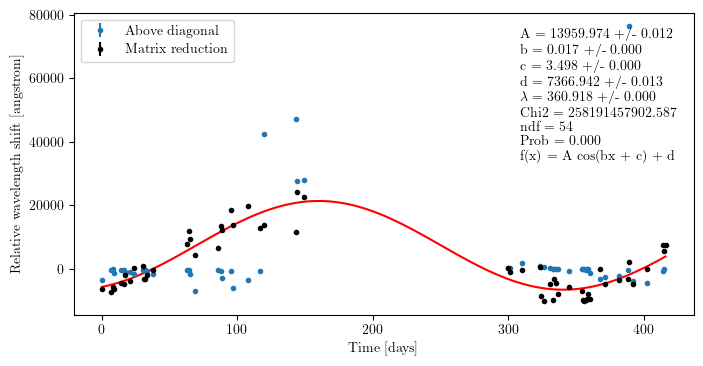

In [5]:
c = 299792458

# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
velocity_shifts = get_above_diagonal(diff_matrix) * c
velocity_shifts_err = get_above_diagonal(diff_matrix_err) * c
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
days = convert_dates_to_relative_days(dates)

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 4))

ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Relative wavelength shift [angstrom]")
ax1.errorbar(days[:-1], velocity_shifts, yerr=velocity_shifts_err, fmt=".", color="C0", label="Above diagonal")

# Fit
x = days
y = np.asarray(final_shifts[:]) * c
y_err = np.asarray(final_shifts_err[:]) * c
ax1.errorbar(x, y, yerr=y_err, fmt=".", color="k", label="Matrix reduction")

# Fitting functions:
def func(x, a, b, c, d) :
    return a * np.cos(x * b + c) + d


# ChiSquare fit model:
def model_chi(a, b, c, d) :
    y_fit = func(x, a, b, c, d)
    chi2 = np.sum(((y - y_fit) / y_err)**2)
    return chi2
model_chi.errordef = 1

minuit = Minuit(model_chi, a=2.5, b=1/50, c=1, d=1)
m = minuit.migrad()        
                    
# Plot result
xPeak = np.linspace(x[0], x[len(x)-1], 100)
ax1.plot(xPeak, func(xPeak, *minuit.values[:]), '-r')

Npoints = len(x)
Nvar = 4                                        # Number of variables
Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

a, a_err = minuit.values['a'], minuit.errors['a']
b, b_err = minuit.values['b'], minuit.errors['b']
c, c_err = minuit.values['c'], minuit.errors['c']
d, d_err = minuit.values['d'], minuit.errors['d']
wavel, wavel_err = (2 * np.pi)/b, np.sqrt((2 * np.pi)**2*b_err**2/b**4)

d = {'A = ':   [a, a_err],
    'b = ':    [b, b_err],
    'c = ':    [c, c_err],
    'd = ':    [d, d_err],
    '$\lambda = $':    [wavel, wavel_err],
    'Chi2 = ':     Chi2_fit,
    'ndf = ':      Ndof_fit,
    'Prob = ':     Prob_fit,
    'f(x) = ':     "A cos(bx + c) + d"
}

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.72, 0.95, text, ax1, fontsize=10, color='black')
ax1.legend(loc = "upper left")

# fig.savefig("shift_non_bary_centric.pdf", bbox_inches="tight", dpi=300)